In [440]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [441]:
import numpy as np
import pandas as pd
from scipy import fft

In [442]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker

import seaborn as sns

mpl.rcParams['figure.figsize'] = (25, 5)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [443]:
# load stations temps
df =  pd.read_csv('../data/raw/gef2012-load/temperature_history.csv')
df = df.set_index(['station_id','year','month','day'])
# convert h1..h24 to 'hours' columns 0..23
df.columns = [int(x[1:])-1 for x in df.columns]
# wide to long using melt
df = pd.melt(df.reset_index(), id_vars=['station_id','year','month','day'], value_vars=range(24), var_name='hour', value_name='temp')
df['temp'] = (df['temp'].astype(float)-32)*5/9
df['dt'] = pd.to_datetime(df[['year','month', 'day', 'hour']])
df = df.sort_values(['station_id', 'dt']).set_index(['station_id', 'dt'])
df = df.drop(columns=['year','month','day', 'hour'])
df = df.unstack('station_id')
df.columns = [f's{x[1]}' for x in  df.columns]
df_stations = df.copy()

<AxesSubplot:xlabel='dt'>

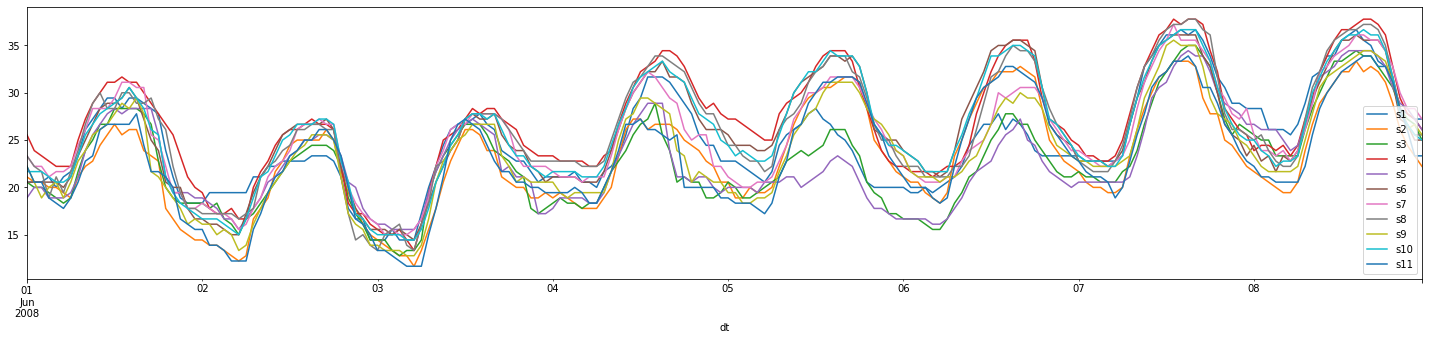

In [444]:
# plot a week of hourly data
df_stations["2008-06-01":"2008-06-08"].plot()

<AxesSubplot:xlabel='dt'>

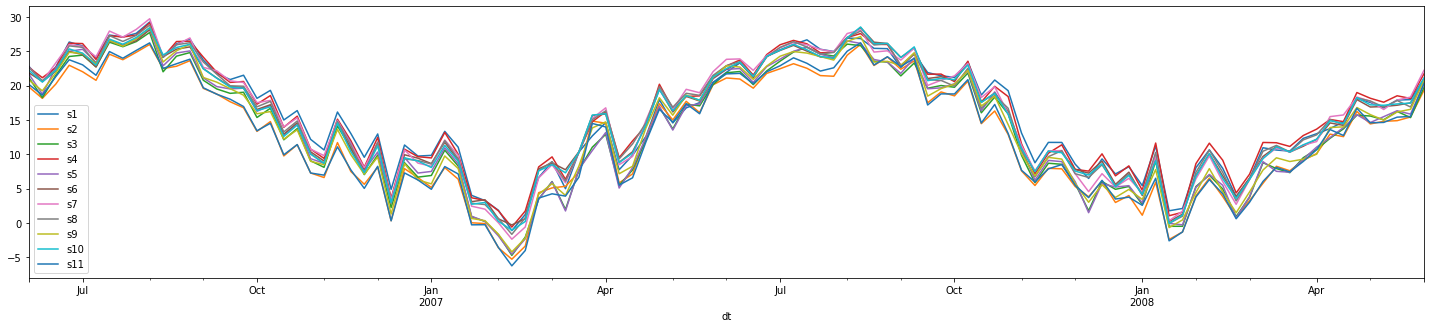

In [445]:
# two years of data resampled weekly
df_stations["2006-06-01":"2008-06-01"].resample('W-MON').mean().plot()

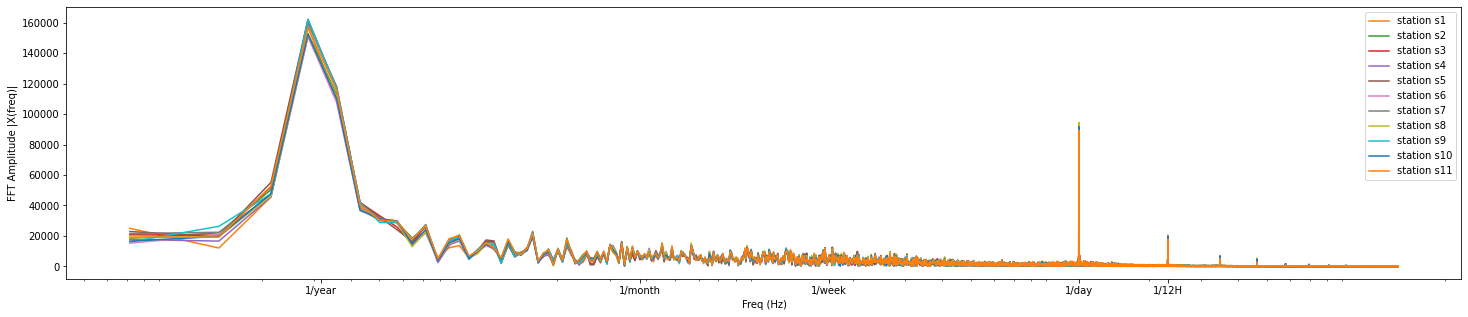

In [446]:
# fft analysis
from scipy.fftpack import fft, ifft

fig1, ax1 = plt.subplots()

for i in range(1,12):
    x = df_stations[:"2008-06-01"][f's{i}'].values

    X = fft(x)
    N = len(X)
    n = np.arange(N)
    # get the sampling rate
    sr = 1 / (60*60)
    T = N/sr
    freq = n/T 

    # Get the one-sided specturm
    n_oneside = N//2
    # get the one side frequency
    f_oneside = freq[1:n_oneside]

    ax1.plot(f_oneside, np.abs(X[1:n_oneside]),color=colors[i%10], label=f'station s{i}')
    ax1.set_xlabel('Freq (Hz)')
    ax1.set_ylabel('FFT Amplitude |X(freq)|')
    ax1.set_xscale('log')
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.set_xticks(ticks=[sr/(365*24), sr/(30.5*24),sr/(7*24), sr/24, sr/12], labels=['1/year', '1/month', '1/week', '1/day', '1/12H'])
    
ax1.legend()
plt.show()

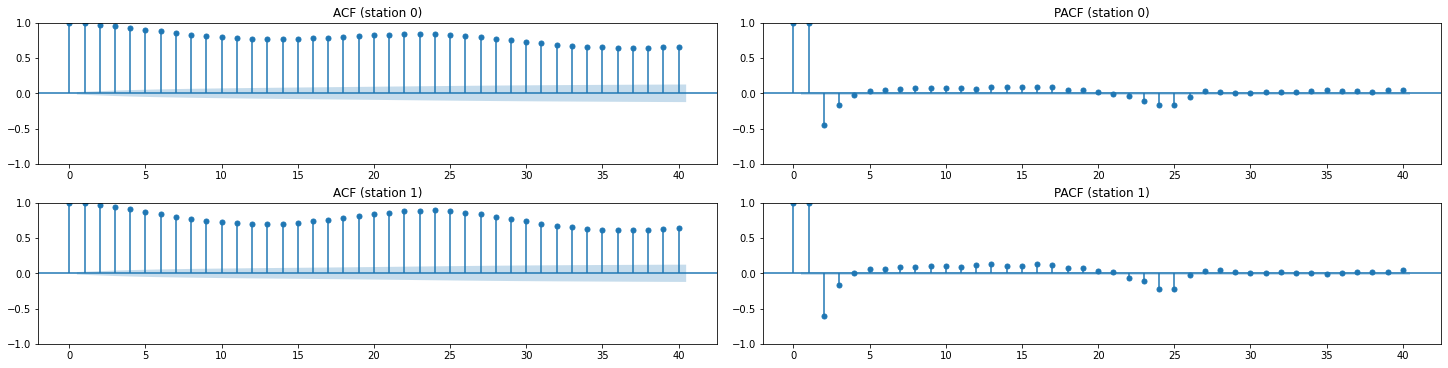

In [447]:
import statsmodels.api as sm
n = 2 # change to 11 to show all stations 
fig, ax = plt.subplots(n, 2, figsize=(20, 5), constrained_layout=True)
for i in range(n): 
    x = df_stations["2007-01-01":"2008-06-01"][f's{i+1}']
    sm.graphics.tsa.plot_acf(x.values.squeeze(), lags=40, ax=ax[i, 0], title=f'ACF (station {i})')
    sm.graphics.tsa.plot_pacf(x.values.squeeze(), lags=40, ax=ax[i, 1], title=f'PACF (station {i})')
plt.show()

In [448]:
# # load zones load
df=  pd.read_csv('../data/raw/gef2012-load/Load_history.csv',thousands=',')

df = df.set_index(['zone_id','year','month','day'])

# convert h1..h24 to 'hours' columns 0..23
df.columns = [int(x[1:])-1 for x in df.columns]

# wide to long using melt
df = pd.melt(df.reset_index(), id_vars=['zone_id','year','month','day'], value_vars=range(24), var_name='hour', value_name='load')

df['load'] = df['load'].astype(float)

df['dt'] = pd.to_datetime(df[['year','month', 'day', 'hour']])
df = df.sort_values(['zone_id', 'dt']).set_index(['zone_id', 'dt'])
df = df.drop(columns=['year','month','day', 'hour'])
df =df.unstack('zone_id').copy()
df.columns = [f'z{x[1]}' for x in  df.columns]

df_load=df.copy()
df_load.head()

,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,z11,z12,z13,z14,z15,z16,z17,z18,z19,z20
dt,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:00:00,16853.0,126259.0,136233.0,484.0,6829.0,133088.0,136233.0,3124.0,75243.0,23339.0,90700.0,118378.0,20673.0,21791.0,65970.0,28752.0,30645.0,200946.0,82298.0,79830.0
2004-01-01 01:00:00,16450.0,123313.0,133055.0,457.0,6596.0,129909.0,133055.0,2956.0,67368.0,22100.0,86699.0,112480.0,19666.0,21400.0,64600.0,27851.0,30461.0,195835.0,79827.0,77429.0
2004-01-01 02:00:00,16517.0,119192.0,128608.0,450.0,6525.0,125717.0,128608.0,2953.0,64050.0,21376.0,84243.0,108435.0,19020.0,20998.0,63843.0,27631.0,30197.0,194093.0,77728.0,75558.0
2004-01-01 03:00:00,16873.0,117507.0,126791.0,448.0,6654.0,124162.0,126791.0,2914.0,63861.0,21335.0,84285.0,107224.0,18841.0,21214.0,64023.0,27986.0,30264.0,194708.0,76433.0,75709.0
2004-01-01 04:00:00,17064.0,118343.0,127692.0,444.0,6977.0,125320.0,127692.0,3221.0,75852.0,21564.0,86087.0,108870.0,19310.0,21830.0,65679.0,29160.0,30907.0,202458.0,78172.0,77475.0


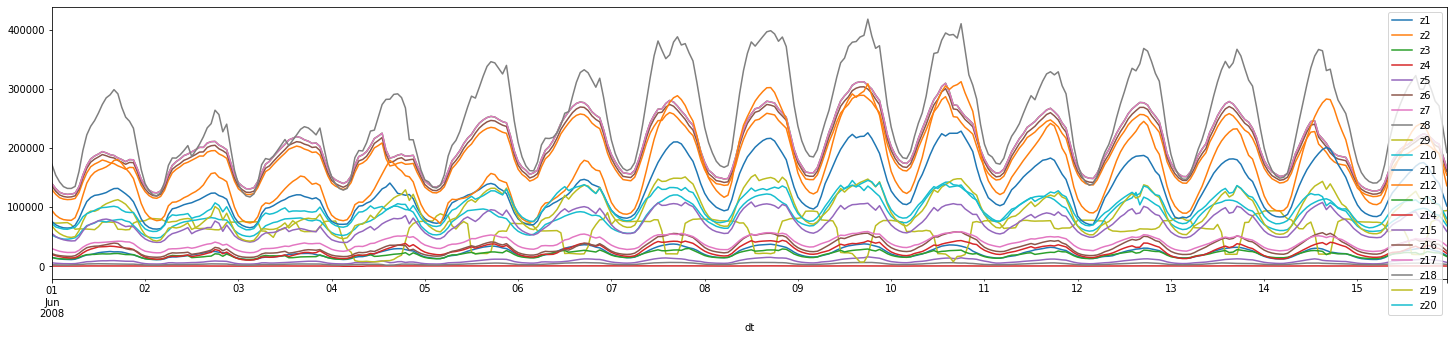

In [449]:
df_load["2008-06-01":"2008-06-15"].plot();

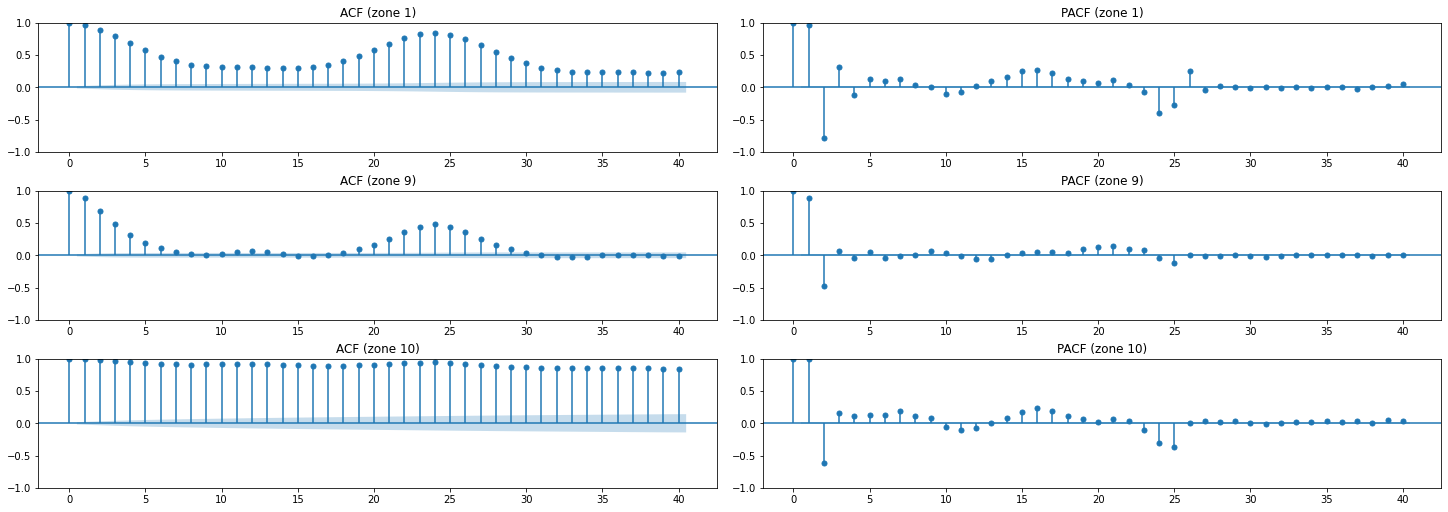

In [450]:
import statsmodels.api as sm
sel = [1,9,10] # change to range(20) to show all stations 
fig, ax = plt.subplots(len(sel), 2, figsize=(20, 7), constrained_layout=True)
for i, v in enumerate(sel): 
    x = df_load["2007-01-01":"2008-06-01"][f'z{v}']
    sm.graphics.tsa.plot_acf(x.values.squeeze(), lags=40, ax=ax[i, 0], title=f'ACF (zone {v})')
    sm.graphics.tsa.plot_pacf(x.values.squeeze(), lags=40, ax=ax[i, 1], title=f'PACF (zone {v})')
plt.show()

In [451]:
df = df_load.join(df_stations)
df = df[df.index < '2008-06-30 00:00:00']
desc = df.describe().T
desc['na'] = df.isna().sum()
desc

,count,mean,std,min,25%,50%,75%,max,na
z1,38064.0,18641.241488,5796.667521,7319.000000,14415.000000,17349.500000,22024.250000,45547.000000,1344
z2,38064.0,173748.222730,34996.374374,82672.000000,149160.500000,170451.500000,196107.750000,321509.000000,1344
z3,38064.0,187474.692781,37761.160010,89204.000000,160943.500000,183917.500000,211600.750000,346909.000000,1344
z4,38064.0,498.803804,121.665345,0.000000,414.000000,490.000000,575.000000,1104.000000,1344
z5,38064.0,7766.504387,2606.447348,1525.000000,5798.000000,7343.000000,9448.000000,18706.000000,1344
z6,38064.0,181513.962563,37294.490362,86652.000000,155603.750000,177697.500000,205354.750000,339927.000000,1344
z7,38064.0,187474.692781,37761.160010,89204.000000,160943.500000,183917.500000,211600.750000,346909.000000,1344
z8,38064.0,3773.782498,1010.179244,1720.000000,3026.000000,3649.000000,4463.000000,7817.000000,1344
z9,38064.0,67622.125473,18769.439340,0.000000,63777.000000,72135.000000,79212.000000,100128.000000,1344
z10,38064.0,32491.972467,17735.246736,7193.000000,22797.750000,26884.000000,34157.500000,145023.000000,1344


s1     0.940581
s2     0.943141
s3     0.957310
s4     0.955277
s5     0.951411
s6     0.956629
s7     0.965370
s8     0.956580
s9     0.956002
s10    0.956611
s11    0.940581
dtype: float64

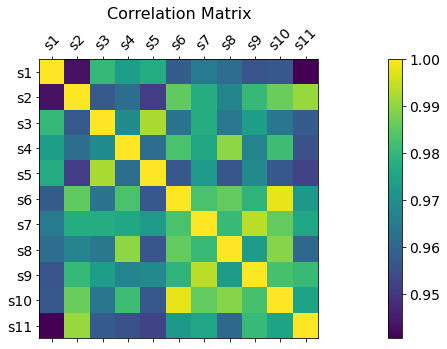

In [452]:
# station cross-correlation
f = plt.figure()
d = df_stations
plt.matshow(d.corr(), fignum=f.number)
plt.xticks(range(d.select_dtypes(['number']).shape[1]), d.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(d.select_dtypes(['number']).shape[1]), d.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
d.corr().min()

z1     0.904877
z2     0.868045
z3     0.868045
z4     0.733925
z5     0.891531
z6     0.878890
z7     0.868045
z8     0.874338
z9    -0.229298
z10    0.426437
z11    0.905915
z12    0.880397
z13    0.849485
z14    0.879523
z15    0.873775
z16    0.907042
z17    0.898647
z18    0.925051
z19    0.909205
z20    0.910531
dtype: float64

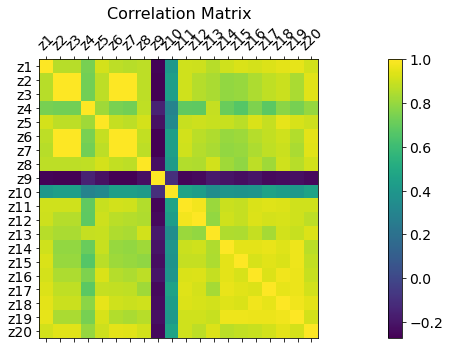

In [453]:
#load cross-corrrelation
f = plt.figure()
d = df_load.copy()
plt.matshow(d.corr(), fignum=f.number)
plt.xticks(range(d.select_dtypes(['number']).shape[1]), d.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(d.select_dtypes(['number']).shape[1]), d.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
d.corr().median()

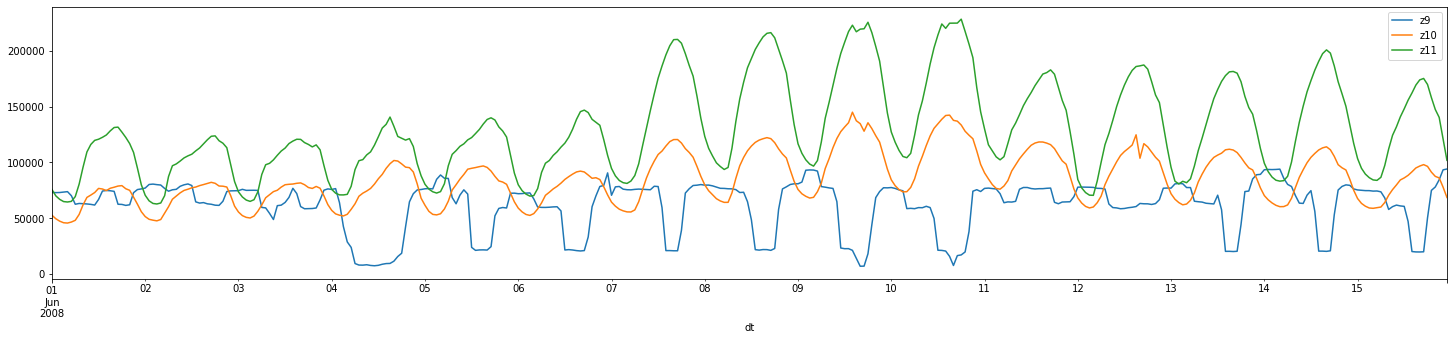

In [454]:
# z9 and z10 are different
df_load["2008-06-01":"2008-06-15"][['z9','z10','z11']].plot();

In [455]:
# stations are highly correlated: calculate station mean, min, max, std
df['s.avg'] = df[[f's{i}'for i in range(1,12)]].mean(axis=1)
df['s.min'] = df[[f's{i}'for i in range(1,12)]].min(axis=1)
df['s.max'] = df[[f's{i}'for i in range(1,12)]].max(axis=1)
df['s.std'] = df[[f's{i}'for i in range(1,12)]].std(axis=1)

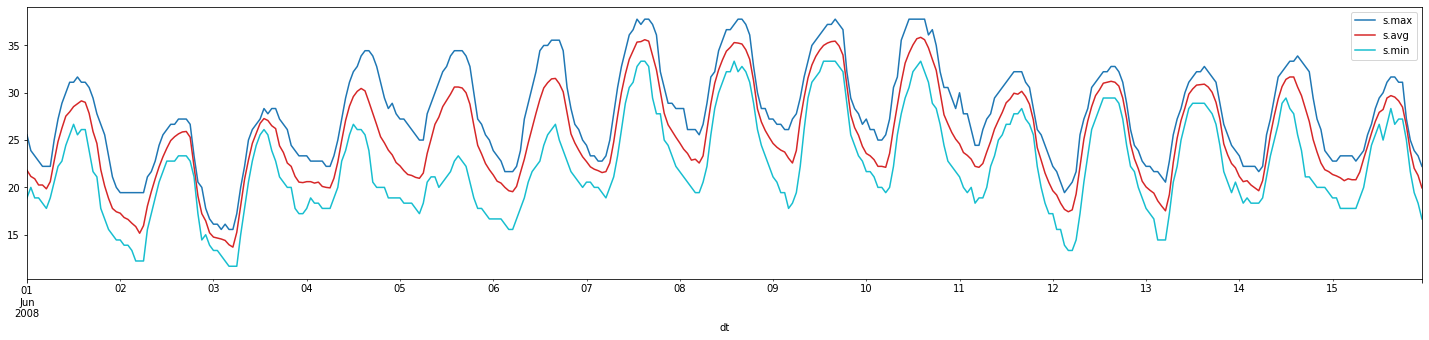

In [456]:
df["2008-06-01":"2008-06-15"][['s.max','s.avg','s.min']].plot(color=['#1f77b4','#d62728','#17becf']);

In [457]:
# minimum load
minload_temp = df['s.avg'].median()
minload_temp

14.696969696969699

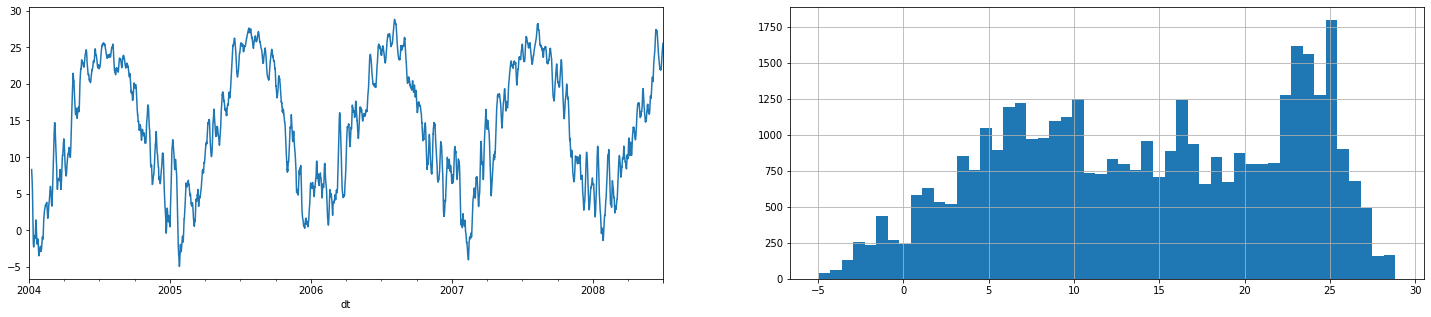

In [458]:
fig, ax = plt.subplots(1,2)
# stations rolling weekly std (averaged) over the years
df['s.avg'].rolling(24*7).mean().plot(ax = ax[0]);
# ... and its histogram
df['s.avg'].rolling(24*7).mean().hist(bins=50, ax = ax[1]);

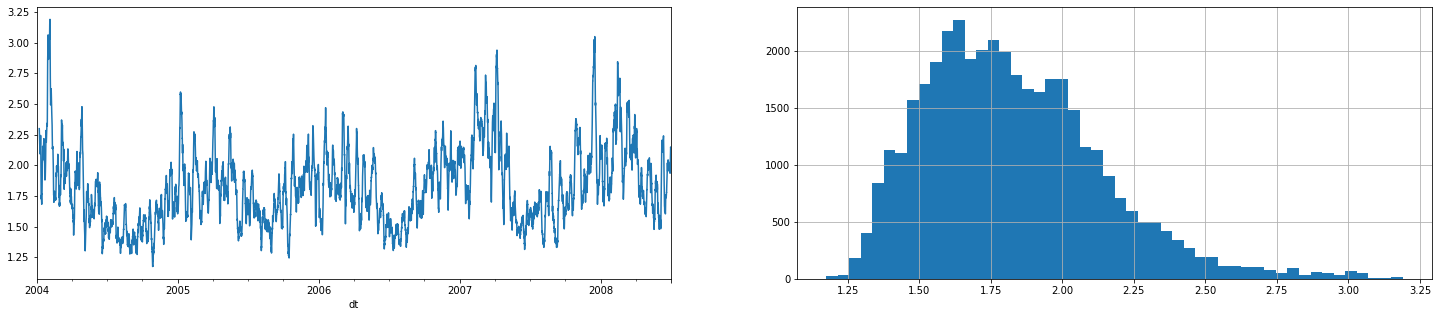

In [459]:
fig, ax = plt.subplots(1,2)
# stations rolling weekly std (averaged) over the years
df['s.std'].rolling(24*7).mean().plot(ax = ax[0]);
# ... and its histogram
df['s.std'].rolling(24*7).mean().hist(bins=50, ax = ax[1]);

In [460]:
# correlate load with temp (averaged over  all stations)
d = dict()
for t in ["high", "low"]:
    d[t] = dict()
    for s in ['s.avg', 's.min', 's.max']:
        d[t][s] = dict()
        for i in range(1,21):
            f = df[s]<minload_temp if t=='low' else df[s]>=minload_temp
            d[t][s][f'z{i}'] = df[f][[f'z{i}', s]].corr().iloc[0,1]

In [461]:
a = pd.DataFrame(d['high'])
a['temp'] = 'high'
b = pd.DataFrame(d['low'])
b['temp'] = 'low'
d = pd.concat([a,b], axis=0)
d.index.name = 'zone_id'
d = d.reset_index()
d = d.set_index(['zone_id', 'temp'])
d = d.stack()
d = d.reset_index()
d.columns = ['zone_id', 'temp', 'station stats', 'corr']
d.head(5)

,zone_id,temp,station stats,corr
0,z1,high,s.avg,0.773062
1,z1,high,s.min,0.753100
2,z1,high,s.max,0.714219
3,z2,high,s.avg,0.740792
4,z2,high,s.min,0.756620


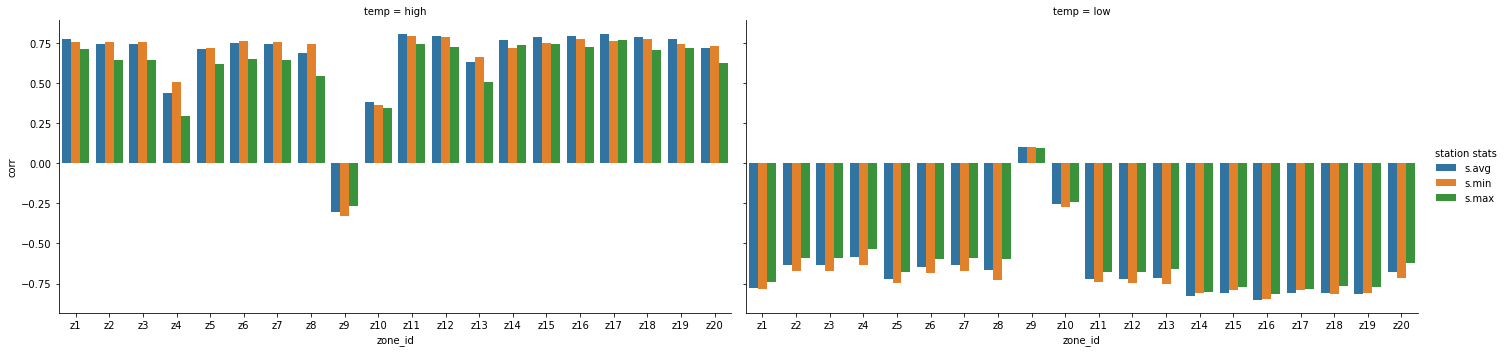

In [462]:
sns.catplot(data=d, kind="bar", x='zone_id', y='corr', hue="station stats", col="temp", height=5, aspect=2)

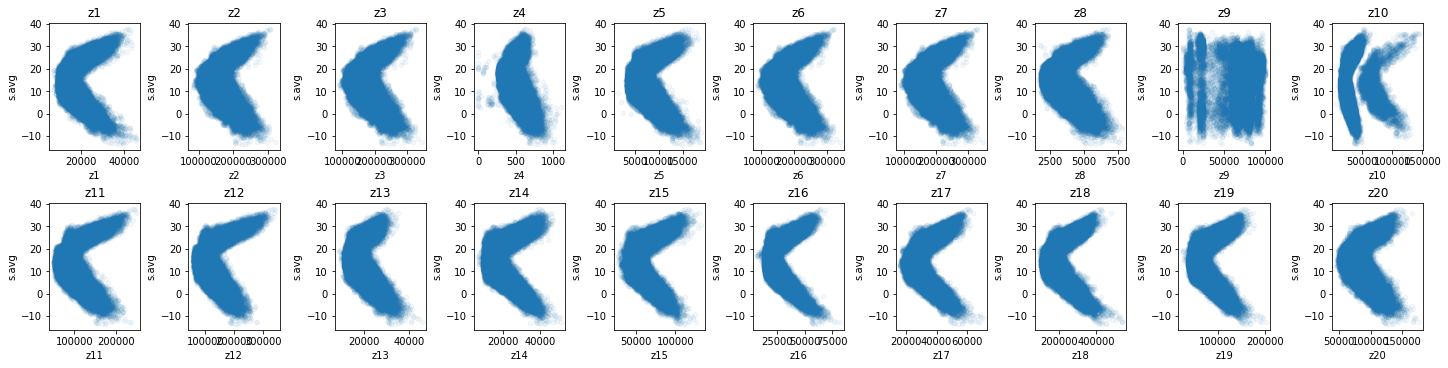

In [463]:
fig, ax = plt.subplots(2,10, constrained_layout=True)
for i in range(2):
    for j in range(10):
        df.plot.scatter(f'z{i*10+j+1}', 's.avg', figsize=(20, 5), ax=ax[i,j], alpha=0.05, title=f'z{i*10+j+1}')

In [464]:
#intuition: z4: winter usage (maybe montain area), z9: industrial, z10: mixed use: residential/manufaturing

In [465]:
df.head(3)

,z1,z2,z3,z4,z5,z6,z7,z8,z9,z10,...,s6,s7,s8,s9,s10,s11,s.avg,s.min,s.max,s.std
dt,,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:00:00,16853.0,126259.0,136233.0,484.0,6829.0,133088.0,136233.0,3124.0,75243.0,23339.0,...,6.666667,7.222222,6.111111,5.000000,5.555556,2.222222,5.757576,2.222222,7.777778,1.708236
2004-01-01 01:00:00,16450.0,123313.0,133055.0,457.0,6596.0,129909.0,133055.0,2956.0,67368.0,22100.0,...,6.111111,6.666667,6.666667,3.888889,6.111111,0.000000,5.151515,0.000000,7.777778,2.264745
2004-01-01 02:00:00,16517.0,119192.0,128608.0,450.0,6525.0,125717.0,128608.0,2953.0,64050.0,21376.0,...,5.555556,5.000000,5.555556,2.222222,6.111111,-0.555556,4.242424,-0.555556,7.222222,2.253567


In [466]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour

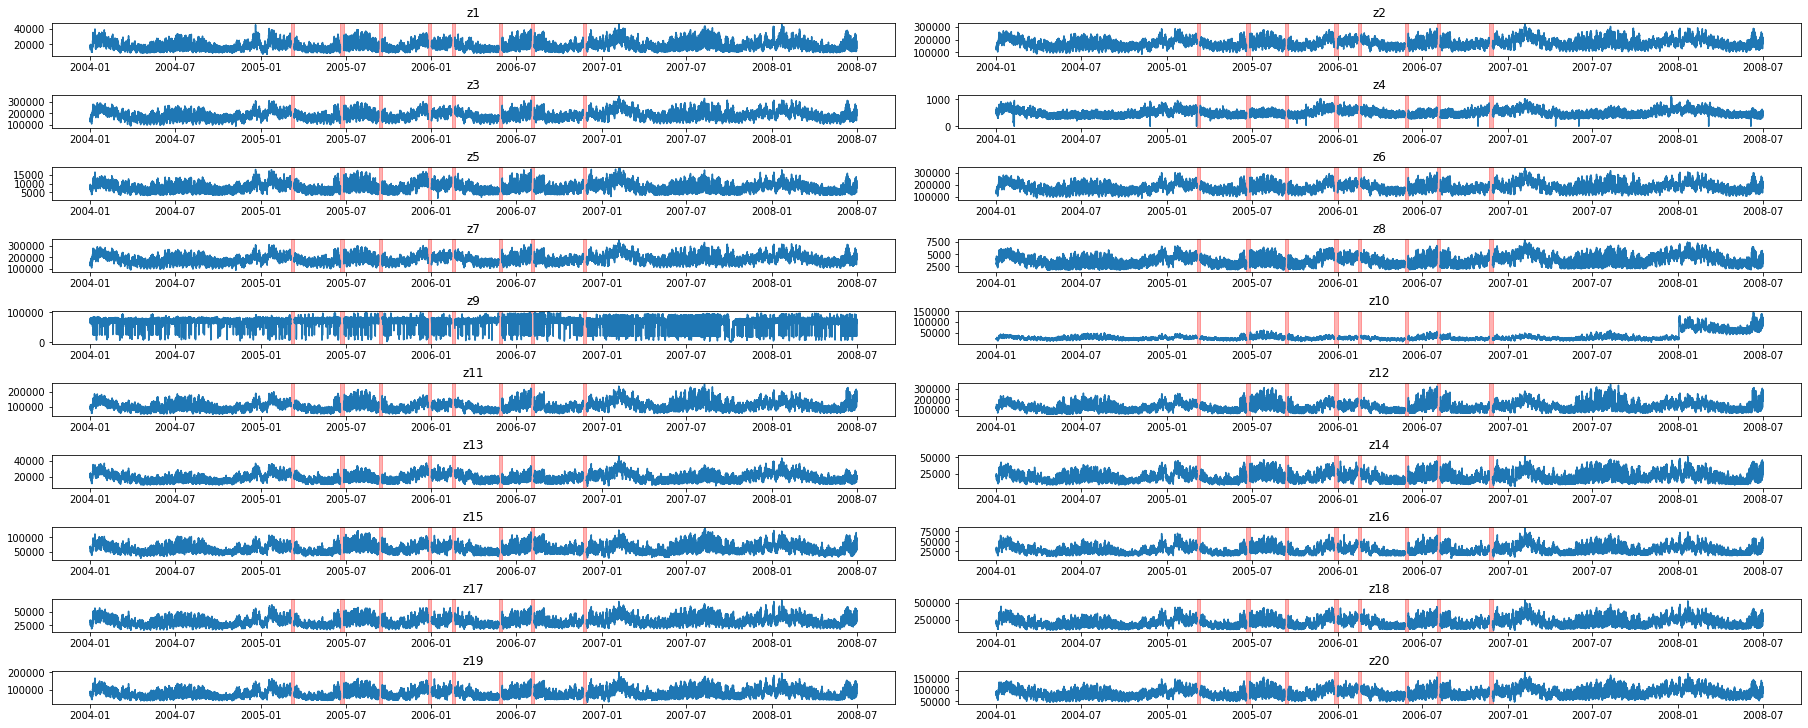

In [467]:
gaps = dict()
for z in range(1,21):
    gaps[f'z{z}'] = dict()
    for k, g in df[['year', 'month', f'z{z}']].groupby(['year', 'month']):
        s = g[f'z{z}']
        if not isinstance(s[s.isna()].index.min(), type(pd.NaT)):
            gaps[f'z{z}'][k] = [ s[s.isna()].index.min(), s[s.isna()].index.max()]

from matplotlib.dates import date2num

fig, ax = plt.subplots(10, 2, figsize=(25,10),constrained_layout=True)
for i in range(20):
    axis =ax[i//2,i%2]
    axis.plot(df.index,df[f'z{i+1}'])
    axis.set_title(f'z{i+1}')
    for k, v in gaps[f'z{i+1}'].items():
        axis.axvspan(date2num(v[0]), date2num(v[1]), color="red", alpha=0.3)

In [468]:
import os
import sys

# from https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [469]:
from IPython.display import display, display_markdown
from prophet import Prophet

In [470]:
def run_prophet(df, target, regressors=None, check_anomalies=True, fill_missing_inplace=True):
    regressors = [] if regressors is None else regressors
    regressors = regressors if type(regressors)==list else [regressors]
    
    # init prophet
    m = Prophet()
    m.add_country_holidays(country_name='US')
    for reg in regressors:
        m.add_regressor(reg)
        
    # prep dataframe
    ts = df[[target]+regressors].copy()
    ts = ts.reset_index()
    ts.columns = ['ds', 'y']+ regressors
    
    with suppress_stdout_stderr():
            m.fit(ts)
            
            if check_anomalies:
                # quick check to verify that the actual is within the upper/lower confidence interval
                pred = m.predict(ts)
                ad = ts.join(pred[['yhat', 'yhat_lower','yhat_upper']])
                anomalies = ad[(ad.y>ad.yhat_upper) & (ad.y<ad.yhat_lower)]
                if len(anomalies)>0:
                    display_markdown(f'Anomalies on ** target {target} **')
                    display(ad[(ad.y>ad.yhat_upper) & (ad.y<ad.yhat_lower)])

            if fill_missing_inplace:
                # backfill gaps 
                # note that this step is only required for statistical forecasting methods
                # which rely directly on auto-regression values not being NaN (such as arima, hw, ses, etc)
                # methods such as regression trees, prophet, boosted ensembles
                # and all SGD solution trained skipping those values will learn just fine
                f = df[target].isna()
                if f.sum()>0:
                    ts = df.loc[f, regressors].reset_index()
                    ts.columns = ['ds']+ regressors
                    pred = m.predict(ts)
                    index = df.reset_index().index
                    df.iloc[index[f], df.columns.get_loc(target)] = pred.yhat
    return m

In [472]:
m = dict()
for i in range(1,21):
    m[i] = run_prophet(df, f'z{i}', 's.min')

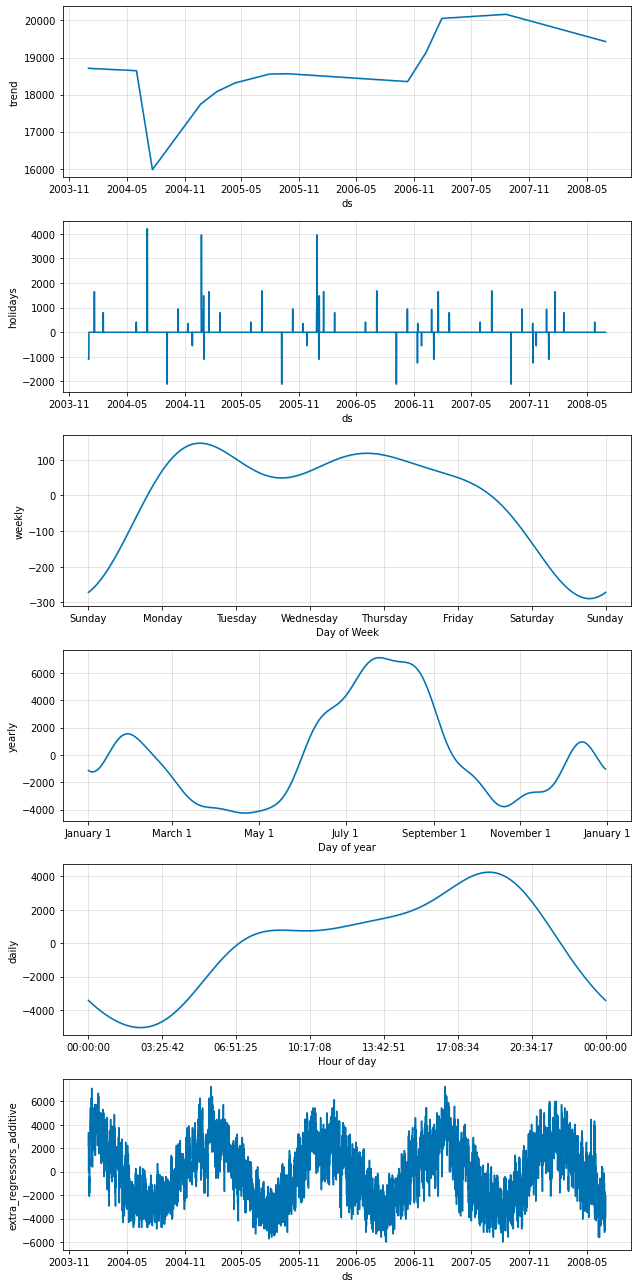

In [473]:
i=1
ts = df[[f'z{i}', 's.min']].copy()
ts = ts.reset_index()
ts.columns = ['ds', 'y', 's.min']
pred = m[i].predict(ts)
m[i].plot_components(pred);

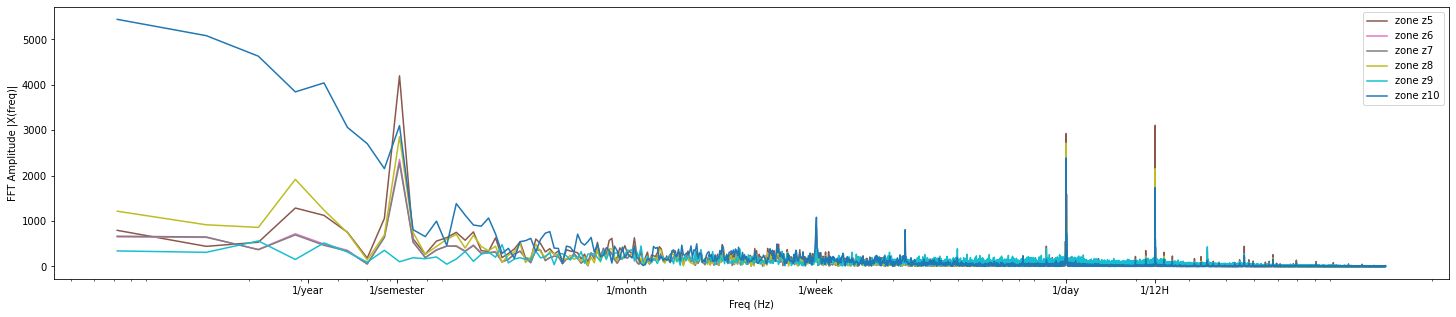

In [512]:
# fft analysis
from scipy.fftpack import fft, ifft

fig1, ax1 = plt.subplots()

# plot zones 5 to 11: those are the most interesting ...
for i in range(5,11):
    x = df[:"2008-06-01"][f'z{i}'].values
    x = x/x.mean()
    
    X = fft(x)
    N = len(X)
    n = np.arange(N)
    # get the sampling rate
    sr = 1 / (60*60)
    T = N/sr
    freq = n/T 

    # Get the one-sided specturm
    n_oneside = N//2
    # get the one side frequency
    f_oneside = freq[1:n_oneside]

    ax1.plot(f_oneside, np.abs(X[1:n_oneside]),color=colors[i%10], label=f'zone z{i}')
    ax1.set_xlabel('Freq (Hz)')
    ax1.set_ylabel('FFT Amplitude |X(freq)|')
    ax1.set_xscale('log')
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax1.set_xticks(ticks=[sr/(1*365*24), sr/(182.5*24), sr/(30.5*24),sr/(7*24), sr/24, sr/12], labels=['1/year', '1/semester', '1/month', '1/week', '1/day', '1/12H'])

ax1.legend()
plt.show()

In [505]:
# save uptill here
# cleaned data 
df.to_parquet('../data/processed/load.parquet')

In [583]:
from patsy import dmatrix, dmatrices

def lag(col, start, end=None):
    s = col

    # create the range of lags
    end = end or start + 1   # if no end provided, we only iterate on start
    r = range(start, end)

    # apply .shift to get lags on every timeseries which are segregated using groupby
    # list comprehension performs the above step for the entire list of lags (start to end)
    ss = [ s.shift(n)for n in r ]

    # concat all the lags together into one dataframe and return it
    df =  pd.concat(ss, axis=1)
    df.columns = [f'{s.name}.lag{x}' for x in r]
    return df.bfill()

def roll(col, window, aggfunc=None):
    if aggfunc is None:
        return col.rolling(window).mean()        
    else:
        return col.rolling(window).apply(aggfunc)

In [584]:
X = dmatrix("0 + lag(z1, 7)", df)
y = df.z1
index = df.index

In [585]:
from lightgbm import LGBMRegressor

In [586]:
lag(df.z1, 7).shape

(39408, 1)

In [587]:
df.z1.shape

(39408,)

In [595]:
m = LGBMRegressor()
m.fit(X[all_splits[0][0]], y[all_splits[0][0]])

In [602]:
index[-7*24:]

DatetimeIndex(['2008-06-23 00:00:00', '2008-06-23 01:00:00',
               '2008-06-23 02:00:00', '2008-06-23 03:00:00',
               '2008-06-23 04:00:00', '2008-06-23 05:00:00',
               '2008-06-23 06:00:00', '2008-06-23 07:00:00',
               '2008-06-23 08:00:00', '2008-06-23 09:00:00',
               ...
               '2008-06-29 14:00:00', '2008-06-29 15:00:00',
               '2008-06-29 16:00:00', '2008-06-29 17:00:00',
               '2008-06-29 18:00:00', '2008-06-29 19:00:00',
               '2008-06-29 20:00:00', '2008-06-29 21:00:00',
               '2008-06-29 22:00:00', '2008-06-29 23:00:00'],
              dtype='datetime64[ns]', name='dt', length=168, freq=None)

In [600]:
m.predict(X[all_splits[4][1]])

array([20211.78643989, 20228.35326291, 20768.08524658, 20532.42353846,
       19518.92520925, 18197.23713282, 16824.78191968, 16845.09630159,
       16427.09837778, 16427.09837778, 16249.51608009, 16307.21542862,
       16669.41024552, 17158.56696436, 16831.92251525, 16538.61084229,
       17588.064602  , 19169.52658903, 20401.81004232, 20202.75608191,
       21421.06018231, 21452.98375345, 21879.38980041, 21241.93817365,
       22811.26890716, 22811.26890716, 21879.38980041, 20529.27222762,
       20320.1646242 , 19691.55910258, 17426.66242262, 16960.84096602,
       17228.19156467, 16307.21542862, 16040.64579222, 16249.51608009,
       17272.81029197, 16649.80479541, 16948.44855158, 17318.72636938,
       17701.73060732, 18308.63288458, 19691.55910258, 19878.48146829,
       21321.46072231, 21417.90315399, 22365.52183145, 22139.33407823,
       21745.73452137, 22838.38898379, 21241.93817365, 21176.4898428 ,
       20440.99989894, 19101.18748114, 16929.12487974, 17020.96323748,
      

In [592]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(test_size=24*7)
all_splits = list(ts_cv.split(X,y))

In [594]:
for i in range(5):
    print(f'fold {i}')
    print('   train:', index[all_splits[i][0]].min(), ' - ', index[all_splits[i][0]].max())
    print('   test :', index[all_splits[i][1]].min(), ' - ', index[all_splits[i][1]].max())
    
    

fold 0
   train: 2004-01-01 00:00:00  -  2008-05-25 23:00:00
   test : 2008-05-26 00:00:00  -  2008-06-01 23:00:00
fold 1
   train: 2004-01-01 00:00:00  -  2008-06-01 23:00:00
   test : 2008-06-02 00:00:00  -  2008-06-08 23:00:00
fold 2
   train: 2004-01-01 00:00:00  -  2008-06-08 23:00:00
   test : 2008-06-09 00:00:00  -  2008-06-15 23:00:00
fold 3
   train: 2004-01-01 00:00:00  -  2008-06-15 23:00:00
   test : 2008-06-16 00:00:00  -  2008-06-22 23:00:00
fold 4
   train: 2004-01-01 00:00:00  -  2008-06-22 23:00:00
   test : 2008-06-23 00:00:00  -  2008-06-29 23:00:00


In [589]:
X_train, y_train, X_test, y_test = 

TypeError: __init__() takes from 1 to 2 positional arguments but 3 positional arguments (and 2 keyword-only arguments) were given

In [262]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(n_splits=5, test_size=24*7)

In [268]:
X = df[['s.min', 'year', 'month', 'day', 'hour']]
y = df['z1']
all_splits = list(ts_cv.split(X,y))

In [269]:
for i in range(5):
    print(f'fold {i}')
    print('   train:', df.iloc[all_splits[i][0]].index.min(), ' - ', df.iloc[all_splits[i][0]].index.max())
    print('   test :', df.iloc[all_splits[i][1]].index.min(), ' - ', df.iloc[all_splits[i][1]].index.max())

fold 0
   train: 2004-01-01 00:00:00  -  2008-05-26 23:00:00
   test : 2008-05-27 00:00:00  -  2008-06-02 23:00:00
fold 1
   train: 2004-01-01 00:00:00  -  2008-06-02 23:00:00
   test : 2008-06-03 00:00:00  -  2008-06-09 23:00:00
fold 2
   train: 2004-01-01 00:00:00  -  2008-06-09 23:00:00
   test : 2008-06-10 00:00:00  -  2008-06-16 23:00:00
fold 3
   train: 2004-01-01 00:00:00  -  2008-06-16 23:00:00
   test : 2008-06-17 00:00:00  -  2008-06-23 23:00:00
fold 4
   train: 2004-01-01 00:00:00  -  2008-06-23 23:00:00
   test : 2008-06-24 00:00:00  -  2008-06-30 23:00:00


In [272]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate

In [274]:
categorical_columns = [
    'year', 
    'month', 
    'day', 
    'hour',
]

one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder="passthrough",
    ),
    HistGradientBoostingRegressor(random_state=42),
)

In [338]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_mean_absolute_percentage_error", "neg_root_mean_squared_error"],
        return_estimator=True
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    mape = -cv_results["test_neg_mean_absolute_percentage_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error     (MAE) : {mae.mean():.2f} +/- {mae.std():.2f}\n"
        f"Root Mean Squared Error (RMSE): {rmse.mean():.2f} +/- {rmse.std():.2f}\n"
        f"Mean Absolute % Error   (MAPE): {mape.mean():.2f} +/- {mape.std():.2f}\n"
    )
    return cv_results

In [339]:
def plot_cv(estimator, X, y, cv):
    all_splits = list(ts_cv.split(X,y))
    df_cv = None
    for i in range(5):
        d = pd.DataFrame(data={'y': y.iloc[all_splits[i][1]], 'yhat':estimator[i].predict(X.iloc[all_splits[i][1]])}, index=y.iloc[all_splits[i][1]].index)
        df_cv = d if df_cv is None else pd.concat([df_cv, d]) 
    fig = df_cv.plot()
    for i in range(5):
        fig.vlines(y.iloc[all_splits[i][1]].index.max(), df_cv.min().min(), df_cv.max().max(), color='green', linestyles ="dashed")

Mean Absolute Error     (MAE) : 2310.10 +/- 965.64
Root Mean Squared Error (RMSE): 3032.19 +/- 1186.29
Mean Absolute % Error   (MAPE): 0.11 +/- 0.03



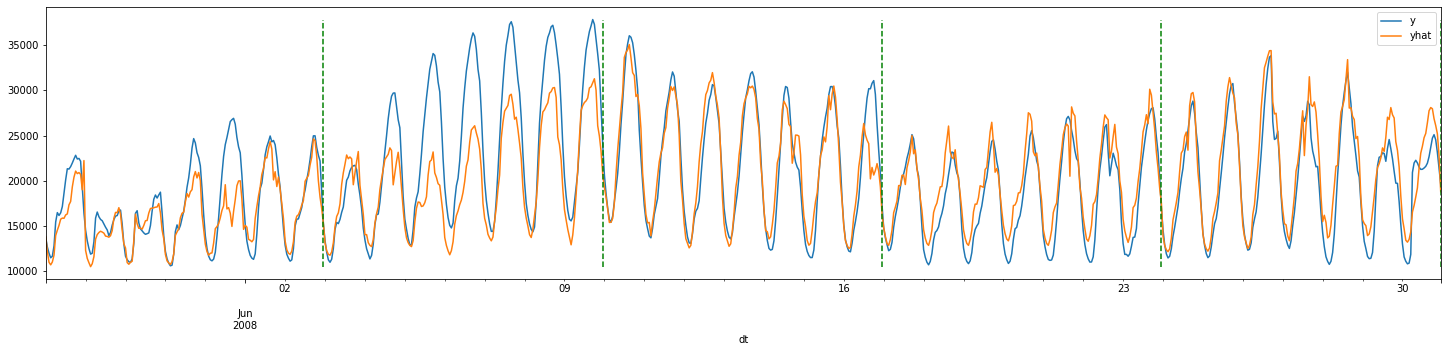

In [340]:
scores = evaluate(gbrt_pipeline, X, y, cv=ts_cv)
plot_cv(scores['estimator'], X, y, cv=ts_cv)

In [318]:
X.iloc[all_splits[i][1]]

,s.min,year,month,day,hour
dt,,,,,
2008-06-24 00:00:00,13.333333,2008,6,24,0
2008-06-24 01:00:00,12.777778,2008,6,24,1
2008-06-24 02:00:00,12.222222,2008,6,24,2
2008-06-24 03:00:00,11.666667,2008,6,24,3
2008-06-24 04:00:00,11.666667,2008,6,24,4
...,...,...,...,...,...
2008-06-30 19:00:00,22.737171,2008,6,30,19
2008-06-30 20:00:00,21.657277,2008,6,30,20
2008-06-30 21:00:00,20.881596,2008,6,30,21


In [ ]:
# predict: recursive or non recursive
#  - non recursive: model takes the input h samples before
#  - yes recursive: models takes the 